In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from glob import glob

from utils.datasets.foscal.patient import FOSCALPatient
from utils.preprocessing.numpy import get_idxs_of_annotated_slices
from metrics import compute_segmentation_metrics

# Load the data

In [6]:
patients = []
patients_label = []
dset_dir = "/data/Datasets/stroke/ISBI_FOSCAL/"
patient_dirs = glob(os.path.join(dset_dir, "*"))
for patient_dir in patient_dirs:
    patient = FOSCALPatient(patient_dir)
    patients.append(patient)
    patients_label.append(patient_dir.split('/')[5][:])

In [7]:
modalities = ["ADC", "DWI"]
masks_daniel = patients[1].get_mask(modalities=modalities, radiologist="Daniel")
masks_andres = patients[1].get_mask(modalities=modalities, radiologist="Andres")

In [8]:
idxs_with_annotations = get_idxs_of_annotated_slices(masks_daniel["ADC"])
masks_daniel["ADC"] = masks_daniel["ADC"][..., idxs_with_annotations]

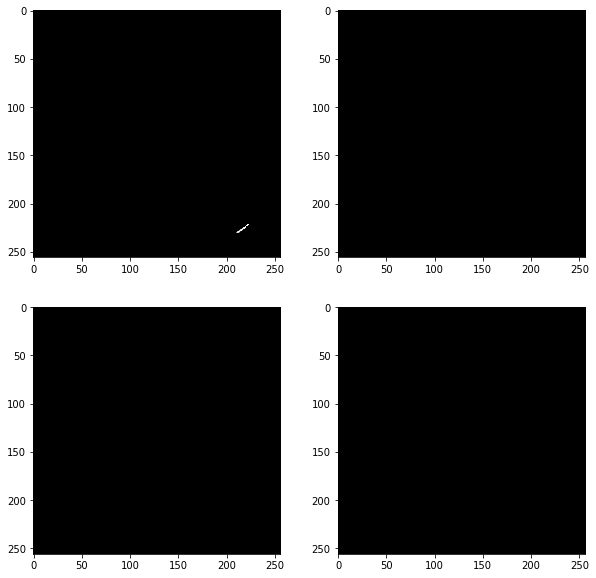

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(masks_daniel["ADC"][..., 0], cmap="gray")
axs[0, 1].imshow(masks_daniel["DWI"][..., 0], cmap="gray")
axs[1, 0].imshow(masks_andres["ADC"][..., 0], cmap="gray")
axs[1, 1].imshow(masks_andres["DWI"][..., 0], cmap="gray")

# Visualize some cases

In [10]:
modalities = ["ADC", "DWI"]
normalization = "min_max"
data = patients[0].get_data(modalities=modalities, normalization=normalization)
masks = patients[0].get_mask(modalities=modalities)

In [11]:
compute_segmentation_metrics(masks["DWI"], masks["ADC"])

{'sens': 0.0,
 'spec': 0.9998570315583333,
 'ppv': 0.0,
 'npv': 0.999799739893307,
 'dsc': 0.0,
 'avd': 0.33389544688026984,
 'hd': 19.339079605813716}

# Agreement between radiologists using ADC masks

In [12]:
def get_agreements(modality):

    Kappas = []
    category = []
    experiments = []

    for idx_p, patient in enumerate(patients):
        masks_daniel = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Daniel")[modality], axis=2)
        masks_andres = np.expand_dims(patient.get_mask(modalities=[modality], radiologist="Andres")[modality], axis=2)

        dims = np.shape(masks_daniel)
        total = dims[0]*dims[1]*dims[2]*dims[3]

        andres_0 = np.sum(masks_andres == 0)
        daniel_0 = np.sum(masks_daniel == 0)
        andres_1 = np.sum(masks_andres == 1)
        daniel_1 = np.sum(masks_daniel == 1)

        andres_daniel_0 = np.sum(np.sum(np.concatenate((masks_andres == 0, masks_daniel == 0), axis=2), axis=2) == 2)
        andres_daniel_1 = np.sum(np.sum(np.concatenate((masks_andres == 1, masks_daniel == 1), axis=2), axis=2) == 2)

        p_0  = (andres_daniel_0 + andres_daniel_1)/total
        si_a = (andres_1/total) * (daniel_1/total)
        no_a = (andres_0/total) * (daniel_0/total)
        p_e  = si_a + no_a
        kappa = (p_0 - p_e)/(1 - p_e)

        Kappas.append(round(kappa, 2))

        if kappa <0.1:
            category.append('No')
        elif 0.1<=kappa<0.2:
            category.append('Slight')
        elif 0.2<=kappa<0.4:
            category.append('Fair')
        elif 0.4<=kappa<0.6:
            category.append('Moderate')
        elif 0.6<=kappa<0.8:
            category.append('Substantial')
        elif 0.8<=kappa<1:
            category.append('Near perfect')
        
        experiments.append(modality)


        """print("--------------------------------")
        print(patients_label[idx_p])
        print(andres_daniel_1, andres_daniel_0)
        print(andres_0, andres_1)
        print(daniel_0, daniel_1)
        print(total)
        print(kappa)
        print("--------------------------------")"""

    #print("kappa primedio:",np.mean(Kappas))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle("ADC vs ADC average kappa:{}".format(round(np.mean(Kappas), 2)))

    g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_label, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

    for idx, container in enumerate(g.containers):
        g.bar_label(container,rotation=45)

    ax1.grid(0.3)
    ax1.set_ylim(0, 1)
    ax1.set_xticklabels(patients_label, rotation=45)

    data = [np.sum(np.array(category) == i) for i in np.unique(category)]
    labels = np.unique(category)
    colors = sns.color_palette('bright')
    ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')

    return Kappas, category, experiments
        
    

In [14]:
def get_agreements_adc_dwi():

    Kappas = []
    category = []
    experiments = []

    for idx_p, patient in enumerate(patients):
        masks_daniel = np.expand_dims(patient.get_mask(modalities=['ADC'], radiologist="Daniel")['ADC'], axis=2)
        masks_andres = np.expand_dims(patient.get_mask(modalities=['DWI'], radiologist="Daniel")['DWI'], axis=2)

        dims = np.shape(masks_daniel)
        total = dims[0]*dims[1]*dims[2]*dims[3]

        andres_0 = np.sum(masks_andres == 0)
        daniel_0 = np.sum(masks_daniel == 0)
        andres_1 = np.sum(masks_andres == 1)
        daniel_1 = np.sum(masks_daniel == 1)

        andres_daniel_0 = np.sum(np.sum(np.concatenate((masks_andres == 0, masks_daniel == 0), axis=2), axis=2) == 2)
        andres_daniel_1 = np.sum(np.sum(np.concatenate((masks_andres == 1, masks_daniel == 1), axis=2), axis=2) == 2)

        p_0  = (andres_daniel_0 + andres_daniel_1)/total
        si_a = (andres_1/total) * (daniel_1/total)
        no_a = (andres_0/total) * (daniel_0/total)
        p_e  = si_a + no_a
        kappa = (p_0 - p_e)/(1 - p_e)

        Kappas.append(round(kappa, 2))

        if kappa <0.1:
            category.append('No')
        elif 0.1<=kappa<0.2:
            category.append('Slight')
        elif 0.2<=kappa<0.4:
            category.append('Fair')
        elif 0.4<=kappa<0.6:
            category.append('Moderate')
        elif 0.6<=kappa<0.8:
            category.append('Substantial')
        elif 0.8<=kappa<1:
            category.append('Near perfect')
        
        experiments.append('ADC vs DWI')


        """print("--------------------------------")
        print(patients_label[idx_p])
        print(andres_daniel_1, andres_daniel_0)
        print(andres_0, andres_1)
        print(daniel_0, daniel_1)
        print(total)
        print(kappa)
        print("--------------------------------")"""

    #print("kappa primedio:",np.mean(Kappas))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle("ADC vs ADC average kappa:{}".format(round(np.mean(Kappas), 2)))

    g = sns.barplot(data={'Kappa':Kappas, 'Patient': patients_label, 'Category': category}, x='Patient', y='Kappa', ax=ax1, color= "mediumpurple")

    for idx, container in enumerate(g.containers):
        g.bar_label(container,rotation=45)

    ax1.grid(0.3)
    ax1.set_ylim(0, 1)
    ax1.set_xticklabels(patients_label, rotation=45)

    data = [np.sum(np.array(category) == i) for i in np.unique(category)]
    labels = np.unique(category)
    colors = sns.color_palette('bright')
    ax2.pie(data, labels=labels, colors = colors, autopct = '%0.0f%%')

    return Kappas, category, experiments

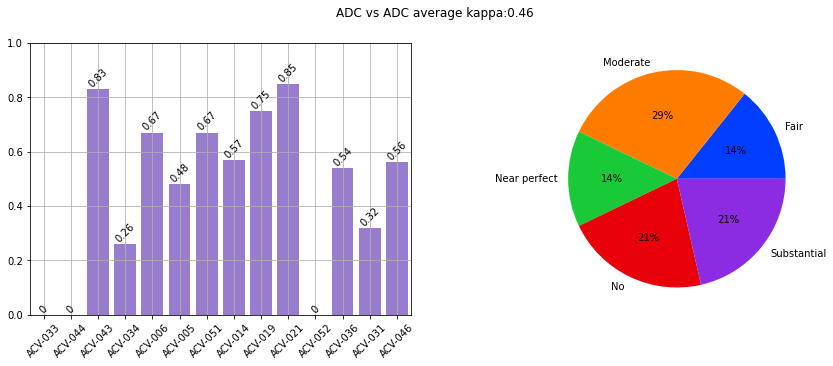

In [15]:
Kappas_ADC, category_ADC, experiments_ADC = get_agreements('ADC')

# Agreement between radiologists using DWI masks

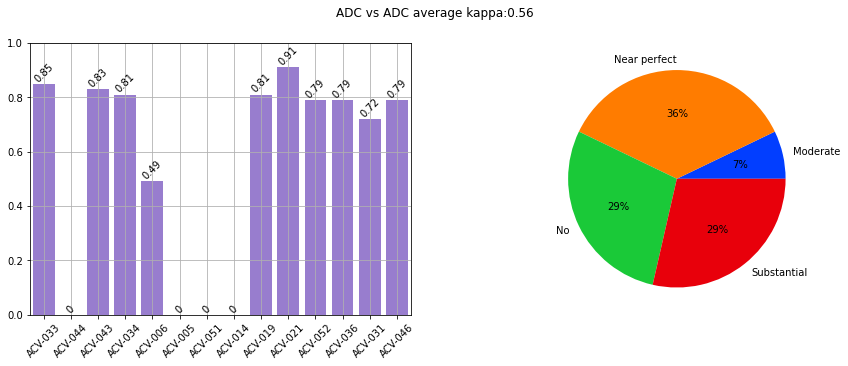

In [16]:
Kappas_DWI, category_DWI, experiments_DWI = get_agreements('DWI')

# Agreement between ADC and DWI masks of the same radiologist

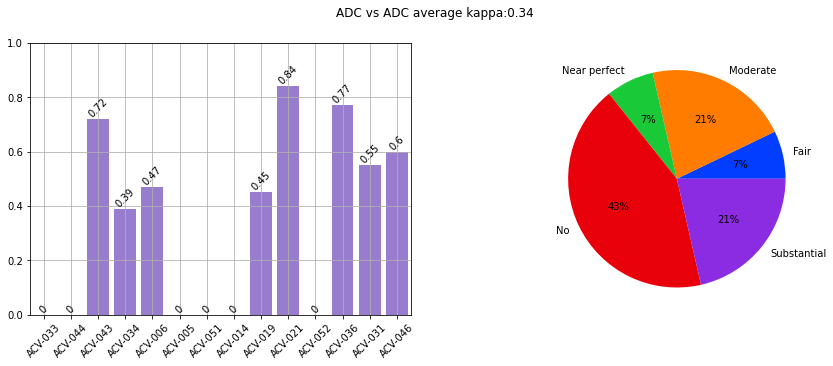

In [17]:
Kappas_ADC_DWI, category_ADC_DWI, experiments_ADC_DWI = get_agreements_adc_dwi()

In [18]:
print(len(Kappas_ADC_DWI), len(category_ADC_DWI), len(experiments_ADC_DWI))

14 14 14


In [19]:
print(len(Kappas_ADC), len(category_ADC), len(experiments_ADC))

14 14 14


In [20]:
print(len(Kappas_DWI), len(category_DWI), len(experiments_DWI))

14 14 14


In [21]:
kappas = []
category = []
experiments = []
patients_string = []

In [22]:
kappas += Kappas_ADC_DWI + Kappas_ADC + Kappas_DWI
category += category_ADC_DWI + category_ADC + category_DWI
experiments += experiments_ADC_DWI + experiments_ADC + experiments_DWI
patients_string += patients_label + patients_label + patients_label

data_plot = pd.DataFrame({'Kappa value':kappas, 'Patients': patients_string, 'Category': category, 'Modality': experiments})
data_plot.head()

,Kappa value,Patients,Category,Modality
0,-0.00,ACV-033,No,ADC vs DWI
1,-0.00,ACV-044,No,ADC vs DWI
2,0.72,ACV-043,Substantial,ADC vs DWI
3,0.39,ACV-034,Fair,ADC vs DWI
4,0.47,ACV-006,Moderate,ADC vs DWI


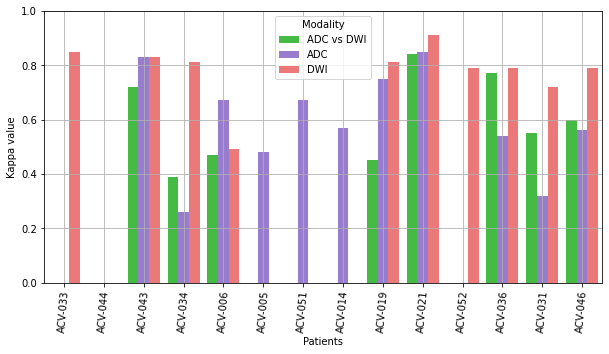

In [23]:
plt.figure(figsize=(10, 5))

g = sns.barplot(data=data_plot, x='Patients', y='Kappa value', hue='Modality', palette=['limegreen', "mediumpurple", '#FF6666'])

"""for idx, container in enumerate(g.containers):
    g.bar_label(container,rotation=90)"""

plt.grid(0.3)
plt.ylim(0, 1)
plt.xticks(rotation = 85)
plt.savefig('Agreements.pdf', bbox_inches='tight')

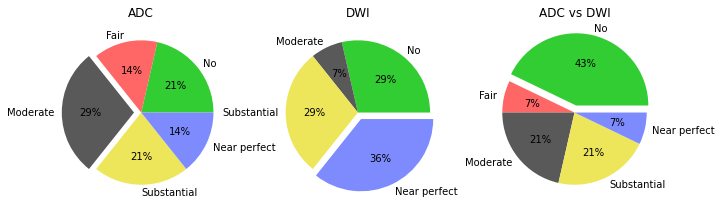

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))

data_plot_pie = data_plot[data_plot['Modality'] == 'ADC']
category_pie = data_plot_pie['Category'].values

labels = ['No', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0.1, 0, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF']
ax1.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
ax1.set_title('ADC')

data_plot_pie = data_plot[data_plot['Modality'] == 'DWI']
category_pie = data_plot_pie['Category'].values
labels = ['No', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0, 0.1) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#5A5959', '#EDE65B', '#7D8BFF']
ax2.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
ax2.set_title('DWI')

data_plot_pie = data_plot[data_plot['Modality'] == 'ADC vs DWI']
category_pie = data_plot_pie['Category'].values
labels = ['No', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0.1, 0, 0, 0, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF']
ax3.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
ax3.set_title('ADC vs DWI')

#plt.legend(labels)
plt.savefig('Pie_agreement.pdf', bbox_inches='tight')


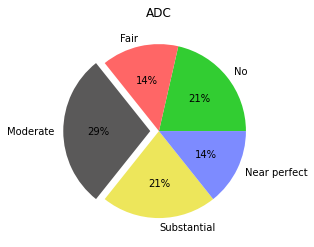

In [29]:
data_plot_pie = data_plot[data_plot['Modality'] == 'ADC']
category_pie = data_plot_pie['Category'].values

labels = ['No', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0.1, 0, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF']
plt.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
plt.title('ADC')
plt.savefig('ADC_agreement.pdf', bbox_inches='tight')

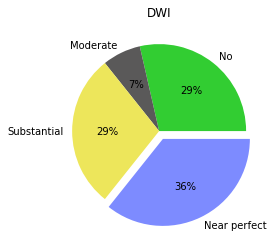

In [30]:
data_plot_pie = data_plot[data_plot['Modality'] == 'DWI']
category_pie = data_plot_pie['Category'].values
labels = ['No', 'Moderate', 'Substantial', 'Near perfect']
explode = (0, 0, 0, 0.1) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#5A5959', '#EDE65B', '#7D8BFF']
plt.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
plt.title('DWI')
plt.savefig('DWI_agreement.pdf', bbox_inches='tight')

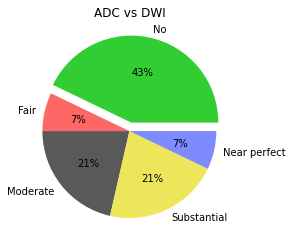

In [35]:
data_plot_pie = data_plot[data_plot['Modality'] == 'ADC vs DWI']
category_pie = data_plot_pie['Category'].values
labels = ['No', 'Fair', 'Moderate', 'Substantial', 'Near perfect']
explode = (0.1, 0, 0, 0, 0) 
data = [np.sum(np.array(category_pie) == i) for i in labels]
colors = ['limegreen', '#FF6666', '#5A5959', '#EDE65B', '#7D8BFF']
plt.pie(data, labels = labels, colors = colors, autopct = '%0.0f%%', explode=explode)
plt.title('ADC vs DWI')
plt.savefig('ADC_DWI_agreement.pdf', bbox_inches='tight')